<a href="https://colab.research.google.com/github/nichepah/ml-colab/blob/master/bof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Predict tap temperature in a Basic Oxygen Furnace using ANN

**Objectives:**
  * Define a neural network (NN) and its hidden layers using the TensorFlow `DNNRegressor` class
  * Train a neural network to learn nonlinearities in the dataset ( DNNRegressor can achieve better performance than a linear regression model)


## Setup

First, let's load and prepare the data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,temp,O2,basicity,FeO
count,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0
mean,10.4,0.8,0.1,0.0,0.0,0.1,108.3,-0.6,9335.2,2185.8,1195.2,0.0,1562.6,6605.3,2.0,8.1
std,4.6,0.3,0.0,0.0,0.0,0.0,38.3,196.9,1460.6,1371.6,1003.8,0.0,379.3,824.5,1.3,9.8
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,9.7,0.8,0.1,0.0,0.0,0.1,117.3,18.0,8346.0,1131.8,0.0,0.0,1631.0,6349.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,121.3,24.0,9300.0,2045.0,1062.0,0.0,1655.0,6600.0,2.5,2.3
75%,13.1,1.0,0.1,0.0,0.0,0.1,124.4,30.0,10158.8,3020.2,1844.2,0.0,1676.0,6861.0,3.0,18.8
max,30.3,2.4,0.9,0.0,0.1,0.2,180.5,449.0,15729.0,8790.0,5211.0,0.0,1765.0,28690.0,9.2,55.0


Index(['converter', 'scrap', 'silicon', 'Mn', 'C', 'S', 'P', 'charging_time',
       'hot_metal_weight', 'blow_start', 'blow_end', 'blow_duration_hh_mm',
       'blow_duration', 'lime', 'iron_ore', 'dolo', 'sinter', 'temp',
       'tap_time', 'O2', 'basicity', 'FeO'],
      dtype='object')

----silicon.describe


count   1708.0
mean       0.8
std        0.3
min        0.0
25%        0.8
50%        0.9
75%        1.0
max        2.4
Name: silicon, dtype: float64

----scrap.describe


count   1708.0
mean      10.4
std        4.6
min        0.0
25%        9.7
50%       11.4
75%       13.1
max       30.3
Name: scrap, dtype: float64

----dtypes
 converter               object
scrap                  float64
silicon                float64
Mn                     float64
C                        int64
S                      float64
P                      float64
charging_time           object
hot_metal_weight       float64
blow_start              object
blow_end                object
blow_duration_hh_mm     object
blow_duration            int64
lime                     int64
iron_ore                 int64
dolo                     int64
sinter                   int64
temp                     int64
tap_time                object
O2                       int64
basicity               float64
FeO                    float64
dtype: object
----shape
 (1708, 22)
----numeric_cols
 ['scrap' 'silicon' 'Mn' 'C' 'S' 'P' 'hot_metal_weight' 'blow_duration'
 'lime' 'iron_ore' 'dolo' 'sinter' 'temp' 'O2' 'basicity' 'FeO']
----non-numeric_cols
 ['converter' 'charging_time' 'blow_start' 'blow_end' 'blow_duration_hh_mm'
 'tap_time']


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,temp,O2,basicity,FeO
count,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0
mean,10.6,0.8,0.1,0.0,0.0,0.1,122.0,24.9,9356.2,2270.8,1212.5,0.0,1654.1,6614.4,2.0,8.0
std,4.3,0.3,0.0,0.0,0.0,0.0,6.5,7.9,1437.0,1369.9,984.8,0.0,41.0,762.4,1.2,9.7
min,0.0,0.0,0.0,0.0,0.0,0.0,91.6,11.0,3633.0,0.0,0.0,0.0,1263.0,2497.0,0.0,0.0
25%,9.8,0.8,0.1,0.0,0.0,0.1,119.2,18.0,8427.8,1240.5,125.2,0.0,1636.0,6354.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,122.0,24.0,9328.5,2104.5,1084.5,0.0,1656.0,6580.0,2.5,2.3
75%,12.9,1.0,0.1,0.0,0.0,0.1,125.0,29.0,10182.8,3106.0,1890.0,0.0,1676.2,6851.5,3.0,18.6
max,30.3,2.4,0.9,0.0,0.1,0.2,180.5,49.0,15729.0,8790.0,4809.0,0.0,1760.0,28690.0,9.2,55.0


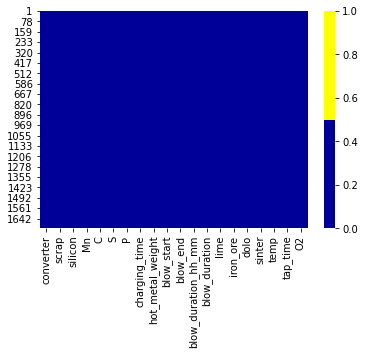

In [ ]:
from __future__ import print_function

import math
 
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
 
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.1f}'.format
 
# add lineterminator too, else it might result in parse error; check in gedit to see the actual formatted data
# raw is better than https://github.com/nichepah/ml-colab/blob/master/bof.csv 
bof_temp_dataframe = pd.read_csv("https://raw.githubusercontent.com/nichepah/ml-colab/master/bof_train.csv", sep=",")
 
# just make sure that what goes is exactly as what you intend to do
display.display(bof_temp_dataframe.describe())
# show just columns
display.display(bof_temp_dataframe.columns)
# show wtf is going on with silicon
print('----silicon.describe')
display.display(bof_temp_dataframe['silicon'].describe())
# compare it with scrap, to know why it's not displayed in describe
# it turned out that it had a non-numerical entry, so it was
# considered as category
print('----scrap.describe')
display.display(bof_temp_dataframe['scrap'].describe())
print("----dtypes\n",bof_temp_dataframe.dtypes)
print("----shape\n",bof_temp_dataframe.shape)

# view numeric types
df_numeric = bof_temp_dataframe.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print("----numeric_cols\n",numeric_cols)
# view non-numeric types
df_non_numeric = bof_temp_dataframe.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("----non-numeric_cols\n",non_numeric_cols)

# silicon went into non-numeric, may be some erroneous data
# for cleaning data https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
# also refer https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
df = bof_temp_dataframe.dropna(subset=['hot_metal_weight']) 
df = df[df.hot_metal_weight > 90]
df = df[df.temp > 1200]
df = df[(df.blow_duration > 10) &(df.blow_duration < 50)]
display.display(df.describe())
cols = df.columns[:20] # first 20 columns 
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))# print("----dtypes of df \n",b.dtypes)
bof_temp_dataframe = df
bof_temp_dataframe = bof_temp_dataframe.reindex(
    np.random.permutation(bof_temp_dataframe.index))

# New Section

In [ ]:
def preprocess_features(bof_temp_dataframe):
  """Prepares input features from the temp data set.
 
  Args:
    bof_temp_dataframe: A Pandas DataFrame expected to contain data
      from the bof data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = bof_temp_dataframe[
    ["scrap",
     "silicon",
     "Mn",
     "C",
     "S",
     "P",
     "hot_metal_weight",
     "blow_duration",
     "lime",
     "iron_ore",
     "dolo",
     "sinter",
     "O2",
     "basicity",
     "FeO"]]
  processed_features = selected_features.copy()
  # scaling of lime, iron, dolo may be taken up here
  # Create a synthetic feature.
  # processed_features["new_col"] = (
  # bof_temp_dataframe["col1"] /
  #  bof_temp_dataframe["col2"])
  processed_features["hot_metal_weight"] = bof_temp_dataframe["hot_metal_weight"]*1000
  return processed_features
 
def preprocess_targets(bof_temp_dataframe):
  """Prepares target features (i.e., labels) from the data set.
 
  Args:
    bof_temp_dataframe: A Pandas DataFrame expected to contain data
      from the bof data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # No need to scale the target.
  output_targets["temp"] = (bof_temp_dataframe["temp"])
  return output_targets

In [ ]:
# Choose the first 1000 out of 1708 examples for training.
training_examples = preprocess_features(bof_temp_dataframe.head(1000))
training_targets = preprocess_targets(bof_temp_dataframe.head(1000))
 
# Choose the last 320 out of 1708 examples for validation.
# Rest will go into testing
validation_examples = preprocess_features(bof_temp_dataframe.tail(320))
validation_targets = preprocess_targets(bof_temp_dataframe.tail(320))
 
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
 
print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,O2,basicity,FeO
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,10.6,0.8,0.1,0.0,0.0,0.1,122133.1,25.0,9394.4,2281.1,1202.2,0.0,6625.4,2.0,7.9
std,4.3,0.3,0.0,0.0,0.0,0.0,6675.9,8.0,1414.9,1384.1,978.8,0.0,828.9,1.3,9.7
min,0.0,0.0,0.0,0.0,0.0,0.0,92000.0,11.0,3633.0,0.0,0.0,0.0,2761.0,0.0,0.0
25%,9.8,0.8,0.1,0.0,0.0,0.1,119000.0,18.0,8483.2,1268.2,55.5,0.0,6357.0,1.5,1.2
50%,11.4,0.9,0.1,0.0,0.0,0.1,122100.0,24.0,9418.5,2104.5,1071.0,0.0,6593.5,2.5,2.2
75%,13.0,1.0,0.1,0.0,0.0,0.1,125100.0,29.0,10183.5,3109.5,1887.0,0.0,6854.2,3.0,18.3
max,26.3,2.4,0.9,0.0,0.1,0.2,180500.0,49.0,15729.0,8790.0,4809.0,0.0,28690.0,9.2,55.0


Validation examples summary:


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,O2,basicity,FeO
count,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0
mean,10.5,0.8,0.1,0.0,0.0,0.1,121627.5,24.8,9237.0,2238.5,1244.5,0.0,6579.8,2.0,8.4
std,4.4,0.3,0.0,0.0,0.0,0.0,5994.7,7.6,1499.7,1326.2,1004.1,0.0,500.4,1.2,9.8
min,0.0,0.0,0.0,0.0,0.0,0.0,91600.0,12.0,3984.0,0.0,0.0,0.0,2497.0,0.0,0.0
25%,9.6,0.8,0.1,0.0,0.0,0.1,119575.0,18.8,8097.0,1194.8,227.2,0.0,6343.8,1.5,1.4
50%,11.3,0.9,0.1,0.0,0.0,0.1,121750.0,24.0,9060.0,2120.5,1095.0,0.0,6557.5,2.5,2.4
75%,12.7,1.0,0.1,0.0,0.0,0.1,124500.0,29.0,10178.2,3073.5,1924.5,0.0,6840.2,2.9,18.9
max,30.3,1.5,0.1,0.0,0.1,0.2,139600.0,49.0,13986.0,6488.0,4083.0,0.0,7822.0,4.6,32.3


Training targets summary:


,temp
count,1000.0
mean,1653.8
std,40.3
min,1263.0
25%,1636.0
50%,1656.0
75%,1676.0
max,1760.0


Validation targets summary:


,temp
count,320.0
mean,1655.0
std,43.1
min,1288.0
25%,1637.0
50%,1656.5
75%,1678.0
max,1760.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Build the Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.
 
  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [ ]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `bof_temp_dataframe` to use as input features for training.
  
  Returns:
    A `DNNRegressor` object trained on the training data.
  """
 
  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["temp"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["temp"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["temp"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
 
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
 
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
 
  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
 
  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 50.**

Run the following block to train a NN model.  

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.

**This is a good one**

    learning_rate=0.5
    steps=1000
    batch_size=32
    hidden_units=[1024, 512]

Check if there is a better model than DNNREGRESSOR


Training model...
RMSE (on training data):
  period 00 : 1586.33
  period 01 : 1336.44
  period 02 : 1086.59
  period 03 : 836.84
  period 04 : 587.30
  period 05 : 338.43
  period 06 : 95.68
  period 07 : 42.81
  period 08 : 42.63
  period 09 : 42.42
Model training finished.
Final RMSE (on training data):   42.42
Final RMSE (on validation data): 36.01


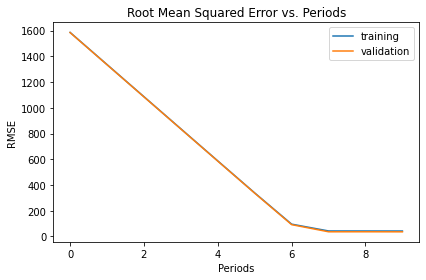

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.5,
    steps=1000,
    batch_size=32,
    hidden_units=[1024, 512],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below to see a possible solution

**NOTE:** This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective (training is nondeterministic, so results may fluctuate a bit each time you run the solution). This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 730.13
  period 01 : 702.26
  period 02 : 687.73
  period 03 : 676.53
  period 04 : 668.41
  period 05 : 664.89
  period 06 : 662.90
  period 07 : 661.84
  period 08 : 660.04
  period 09 : 648.68
Model training finished.
Final RMSE (on training data):   648.68
Final RMSE (on validation data): 686.62


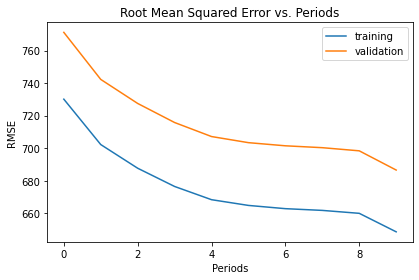

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=500,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


## Modified with smaller step size




## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

Training model...
RMSE (on training data):
  period 00 : 1479.61
  period 01 : 312.38
  period 02 : 579.19
  period 03 : 582.77
  period 04 : 303.09
  period 05 : 551.64
  period 06 : 280.91
  period 07 : 547.70
  period 08 : 266.94
  period 09 : 269.60
Model training finished.
Final RMSE (on training data):   269.60
Final RMSE (on validation data): 258.05


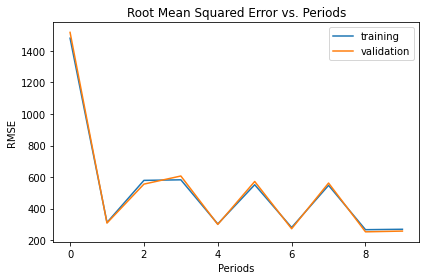

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=50,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


With smaller step size, higher learning rate

Training model...
RMSE (on training data):
  period 00 : 2105.94
  period 01 : 1639.59
  period 02 : 1100.36
  period 03 : 377.09
  period 04 : 403.82
  period 05 : 676.35
  period 06 : 500.79
  period 07 : 538.85
  period 08 : 692.10
  period 09 : 425.98
Model training finished.
Final RMSE (on training data):   425.98
Final RMSE (on validation data): 440.89


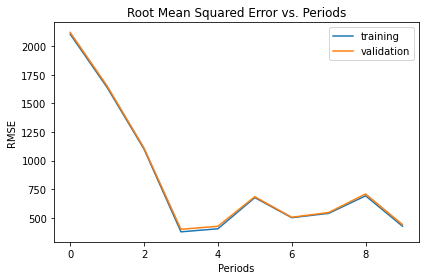

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


Increase batch size

Training model...
RMSE (on training data):
  period 00 : 3536.30
  period 01 : 2963.27
  period 02 : 2564.25
  period 03 : 2153.73
  period 04 : 352.62
  period 05 : 139.62
  period 06 : 150.88
  period 07 : 763.55
  period 08 : 420.98
  period 09 : 500.07
Model training finished.
Final RMSE (on training data):   500.07
Final RMSE (on validation data): 493.53


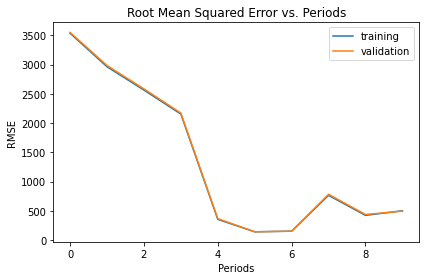

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=20,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


Reduce step size

Training model...
RMSE (on training data):
  period 00 : 759.59
  period 01 : 742.35
  period 02 : 735.93
  period 03 : 731.02
  period 04 : 726.27
  period 05 : 721.50
  period 06 : 716.67
  period 07 : 711.77
  period 08 : 706.85
  period 09 : 701.90
Model training finished.
Final RMSE (on training data):   701.90
Final RMSE (on validation data): 713.82


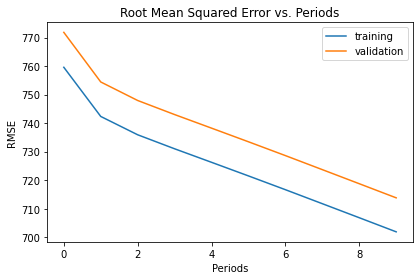

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    hidden_units=[15, 10, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Case 1 with increased batch size


Training model...
RMSE (on training data):
  period 00 : 810.31
  period 01 : 48.50
  period 02 : 48.50
  period 03 : 50.44
  period 04 : 48.50
  period 05 : 50.44
  period 06 : 48.50
  period 07 : 50.44
  period 08 : 48.50
  period 09 : 50.44
Model training finished.
Final RMSE (on training data):   50.44
Final RMSE (on validation data): 52.33


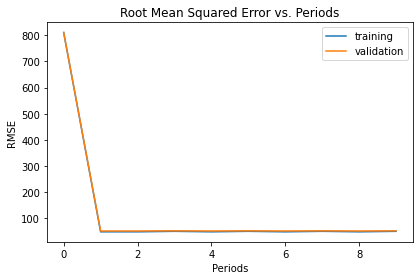

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.1,
    steps=2000,
    batch_size=32,
    hidden_units=[1024, 512],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Try to increase complexity


Training model...
RMSE (on training data):
  period 00 : 203.20
  period 01 : 205.50
  period 02 : 205.74
  period 03 : 208.92
  period 04 : 210.82
  period 05 : 211.59
  period 06 : 214.43
  period 07 : 214.91
  period 08 : 215.71
  period 09 : 216.42
Model training finished.
Final RMSE (on training data):   216.42
Final RMSE (on validation data): 205.26


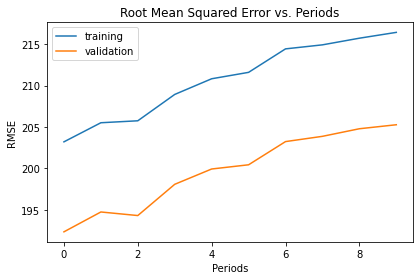

In [10]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=50,
    hidden_units=[1024, 512],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Run the model on test data

A set of data is kept aside as test data. This data is not part of training set.

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

> Indented block

Note that we don't have to randomize the test data, since we will use all records.

We can also assume that data provided is valid.

In [ ]:
from google.colab import drive
drive.mount('drive')

bof_temp_test_data = pd.read_csv("https://raw.githubusercontent.com/nichepah/ml-colab/master/bof_test.csv", sep=",")
 
test_examples = preprocess_features(bof_temp_test_data)
test_targets = preprocess_targets(bof_temp_test_data)
 
predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["temp"], 
                                               num_epochs=1, 
                                               shuffle=False)
 
test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
print("----test_predictions")
print(test_predictions, test_targets["temp"])
# save data and prediction to drive
my_df = pd.DataFrame(data=bof_temp_test_data)
my_df['p_temp'] = test_predictions
my_df.to_csv('pred.csv')
!cp pred.csv "drive/My Drive/myCoLab/"
display.display(my_df.describe)
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))
 
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
----test_predictions
[1353.765  1631.4055 1526.586  1453.0435 1408.0658 1529.4663 1426.8323
 1776.9448 1339.6421 1373.4839 1505.5746 1398.9147 1255.2404 1322.1271
 1348.5681 1346.4915 1424.377  1390.213  1560.9869 1134.3538 1305.3933
 1430.1903 1457.7347 1325.9965 1335.367  1377.282  1202.1592 1405.0638
 1348.5128  933.5546 1263.2916 1430.2828 1281.1879 1350.4904 1223.2927
 1267.6257 1106.8982 1263.9421 1267.8933 1141.0834 1235.2104 1373.4022
 1367.1982 1372.1564 1433.9056 1412.6836 1324.7107 1577.547  1433.4097
 1418.1923 1572.2402 1521.7996 1373.9634 1501.009  1381.5603 1321.6725
 1519.8071 1328.9012 1480.0195 1389.9778 1533.8033 1465.5276 1574.0306
 1572.4572 1594.2167 1516.3896 1504.5247 1565.1755 1444.9329 1493.7145
 1341.112  1414.8914 1450.8499 1509.1375 1466.3507 1268.8761 1327.1001
 1321.4404 1270.8424] 0     1623
1     1616
2     1680
3     1685
4     1700
      ... 

<bound method NDFrame.describe of    converter  scrap  silicon  Mn  C  ...  tap_time    O2 basicity  FeO p_temp
0          A    0.0      0.9 0.1  0  ...     11:36  4044      2.8 21.0 1353.8
1          A   10.7      1.2 0.1  0  ...     12:36  7023      2.7 19.4 1631.4
2          A   11.6      1.2 0.1  0  ...     13:11  7110      0.0  0.0 1526.6
3          A   13.2      0.9 0.1  0  ...     13:31  6540      3.0  4.8 1453.0
4          B    9.7      0.9 0.1  0  ...     14:30  6508      0.0  0.0 1408.1
..       ...    ...      ...  .. ..  ...       ...   ...      ...  ...    ...
74         A   12.4      0.9 0.1  0  ...     12:55  6359      0.0  0.0 1466.4
75         B   11.2      1.2 0.1  0  ...     17:35  6220      1.5  1.9 1268.9
76         B   12.6      1.2 0.1  0  ...     18:19  6550      0.0  0.0 1327.1
77         B   12.2      0.9 0.1  0  ...     19:22  5841      0.0  0.0 1321.4
78         C   11.6      0.9 0.1  0  ...     23:54  6178      0.0  0.0 1270.8

[79 rows x 23 columns]>

Final RMSE (on test data): 300.23
